# Imports

In [2]:
import os
import math 
from tqdm import tqdm

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, Subset
from einops import rearrange, repeat


import numpy as np
import matplotlib.pyplot as plt



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dropout_fn = nn.Dropout1d


# Data Loader

In [6]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms

class ImageClassificationDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['negative', 'positive']
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._load_images()

    def _load_images(self):
        images = []
        for cls in self.classes:
            class_dir = os.path.join(self.root_dir, cls)
            for img_name in os.listdir(class_dir):
                images.append((os.path.join(class_dir, img_name), self.class_to_idx[cls]))
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Define your transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet stats
])

# Create the dataset
dataset = ImageClassificationDataset(root_dir='lateral_flow', transform=transform)

# Calculate the sizes for train and test sets
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size

# Use random_split to create train and test datasets
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoaders for train and test sets
batch_size = 2
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Example usage
print(f"Total dataset size: {total_size}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


def compute_class_weights(dataset):
    class_counts = [0] * len(dataset.dataset.classes)
    for _, label in dataset:
        class_counts[label] += 1
    total_samples = sum(class_counts)
    class_weights = [total_samples / (len(class_counts) * count) for count in class_counts]
    return torch.tensor(class_weights, dtype=torch.float)

# Compute class weights
class_weights = compute_class_weights(train_dataset)
print("Class weights:", class_weights)

Total dataset size: 48
Train dataset size: 38
Test dataset size: 10
Class weights: tensor([1.1875, 0.8636])


tensor(1)


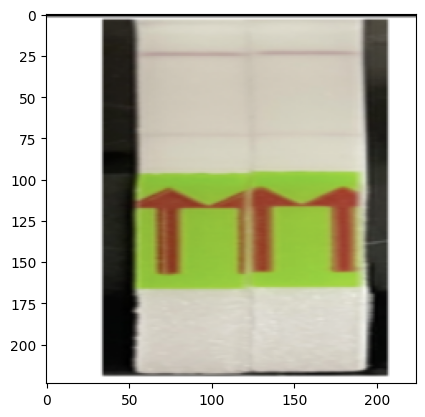

In [7]:
sample = next(iter(train_dataloader))
plt.imshow(sample[0][0].permute(1,2,0).detach().cpu().numpy())
print(sample[1][0])

# Model

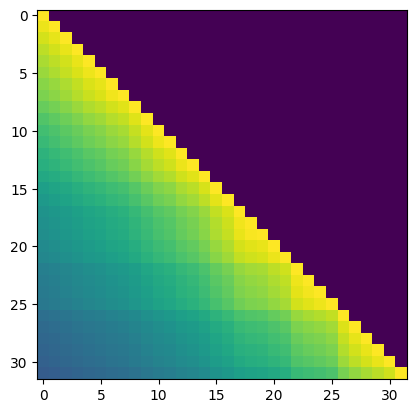

In [13]:
# Copyright (c) 2024, Sukjun Hwang, Aakash Lahoti, Ratish Puduppully, Tri Dao, Albert Gu.
# Base code from https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba2_simple.py

import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from einops import rearrange, repeat
import matplotlib.pyplot as plt
RMSNormGated = None



class RMSNorm(nn.Module):
    def __init__(self, d, p=-1., eps=1e-8, bias=False):
        """
            Root Mean Square Layer Normalization
        :param d: model size
        :param p: partial RMSNorm, valid value [0, 1], default -1.0 (disabled)
        :param eps:  epsilon value, default 1e-8
        :param bias: whether use bias term for RMSNorm, disabled by
            default because RMSNorm doesn't enforce re-centering invariance.
        """
        super(RMSNorm, self).__init__()

        self.eps = eps
        self.d = d
        self.p = p
        self.bias = bias

        self.scale = nn.Parameter(torch.ones(d))
        self.register_parameter("scale", self.scale)

        if self.bias:
            self.offset = nn.Parameter(torch.zeros(d))
            self.register_parameter("offset", self.offset)

    def forward(self, x):
        if self.p < 0. or self.p > 1.:
            norm_x = x.norm(2, dim=-1, keepdim=True)
            d_x = self.d
        else:
            partial_size = int(self.d * self.p)
            partial_x, _ = torch.split(x, [partial_size, self.d - partial_size], dim=-1)

            norm_x = partial_x.norm(2, dim=-1, keepdim=True)
            d_x = partial_size

        rms_x = norm_x * d_x ** (-1. / 2)
        x_normed = x / (rms_x + self.eps)

        if self.bias:
            return self.scale * x_normed + self.offset

        return self.scale * x_normed

def segsum(x):
    """More stable segment sum calculation."""
    T = x.size(-1)
    x = repeat(x, "... d -> ... d e", e=T)
    mask = torch.tril(torch.ones(T, T, device=x.device, dtype=bool), diagonal=-1)
    x = x.masked_fill(~mask, 0)
    x_segsum = torch.cumsum(x, dim=-2)
    mask = torch.tril(torch.ones(T, T, device=x.device, dtype=bool), diagonal=0)
    x_segsum = x_segsum.masked_fill(~mask, -torch.inf)
    return x_segsum

def ssd_minimal_discrete(X, A, B, C, block_len, initial_states=None):
    """
    Arguments:
        X: (batch, length, n_heads, d_head)
        A: (batch, length, n_heads)
        B: (batch, length, n_heads, d_state)
        C: (batch, length, n_heads, d_state)
    Return:
        Y: (batch, length, n_heads, d_head)
    """
    assert X.dtype == A.dtype == B.dtype == C.dtype
    assert X.shape[1] % block_len == 0

    # Rearrange into blocks/chunks
    #print(A.shape)
    X, A, B, C = [rearrange(x, "b (c l) ... -> b c l ...", l=block_len) for x in (X, A, B, C)]
    #print(A.shape)
    A = rearrange(A, "b c l h -> b h c l")
    #print(A.shape)
    A_cumsum = torch.cumsum(A, dim=-1)

    # 1. Compute the output for each intra-chunk (diagonal blocks)
    L = torch.exp(segsum(A))
    Y_diag  = torch.einsum("bclhn,bcshn,bhcls,bcshp->bclhp", C, B, L, X)

    # 2. Compute the state for each intra-chunk
    # (right term of low-rank factorization of off-diagonal blocks; B terms)
    decay_states = torch.exp((A_cumsum[:, :, :, -1:] - A_cumsum))
    states = torch.einsum("bclhn,bhcl,bclhp->bchpn", B, decay_states, X)

    # 3. Compute the inter-chunk SSM recurrence; produces correct SSM states at chunk boundaries
    # (middle term of factorization of off-diag blocks; A terms)
    if initial_states is None:
        initial_states = torch.zeros_like(states[:, :1])
    states = torch.cat([initial_states, states], dim=1)
    decay_chunk = torch.exp(segsum(F.pad(A_cumsum[:, :, :, -1], (1, 0))))
    new_states = torch.einsum("bhzc,bchpn->bzhpn", decay_chunk, states)
    states, final_state = new_states[:, :-1], new_states[:, -1]

    # 4. Compute state -> output conversion per chunk
    # (left term of low-rank factorization of off-diagonal blocks; C terms)
    state_decay_out = torch.exp(A_cumsum)
    Y_off = torch.einsum('bclhn,bchpn,bhcl->bclhp', C, states, state_decay_out)

    # Add output of intra-chunk and inter-chunk terms (diagonal and off-diagonal blocks)
    Y = rearrange(Y_diag+Y_off, "b c l h p -> b (c l) h p")
    return Y, final_state, L

class Hydra(nn.Module):
    def __init__(
        self,
        d_model,
        d_state=64,
        d_conv=7,
        conv_init=None,
        expand=2,
        headdim=64,
        ngroups=1,
        dt_min=0.001,
        dt_max=0.1,
        dt_init_floor=1e-4,
        dt_limit=(0.0, float("inf")),
        learnable_init_states=False,
        activation="swish",
        bias=False,
        conv_bias=True,
        # Fused kernel and sharding options
        chunk_size=256,
        layer_idx=None,  # Absorb kwarg for general module
        device=None,
        dtype=None,
    ):
        factory_kwargs = {"device": device, "dtype": dtype}
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.conv_init = conv_init
        self.expand = expand
        self.d_inner = self.expand * self.d_model
        self.headdim = headdim
        self.ngroups = ngroups
        assert self.d_inner % self.headdim == 0
        self.nheads = self.d_inner // self.headdim
        self.dt_limit = dt_limit
        self.learnable_init_states = learnable_init_states
        self.activation = activation
        self.chunk_size = chunk_size
        self.layer_idx = layer_idx

        # Order: [z, x, B, C, dt]
        d_in_proj = 2 * self.d_inner + 2 * (2 * self.ngroups * self.d_state) + 2 * self.nheads
        self.in_proj = nn.Linear(self.d_model, d_in_proj, bias=bias, **factory_kwargs)

        conv_dim = self.d_inner + 2 * (2 * self.ngroups * self.d_state)
        '''
        self.conv1d = nn.Conv1d(
            in_channels=conv_dim,
            out_channels=conv_dim,
            bias=conv_bias,
            kernel_size=d_conv,
            groups=conv_dim,
            padding=d_conv // 2,
            **factory_kwargs,
        )

        if self.conv_init is not None:
            nn.init.uniform_(self.conv1d.weight, -self.conv_init, self.conv_init)
        # self.conv1d.weight._no_weight_decay = True
        '''
        if self.learnable_init_states:
            self.init_states = nn.Parameter(torch.zeros(self.nheads, self.headdim, self.d_state, **factory_kwargs))
            self.init_states._no_weight_decay = True

        self.act = nn.SiLU()

        # Initialize log dt bias
        dt = torch.exp(
            torch.rand(self.nheads, **factory_kwargs) * (math.log(dt_max) - math.log(dt_min))
            + math.log(dt_min)
        )
        dt = torch.clamp(dt, min=dt_init_floor)
        # Inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        inv_dt = dt + torch.log(-torch.expm1(-dt))
        self.dt_bias = nn.Parameter(inv_dt)
        # Just to be explicit. Without this we already don't put wd on dt_bias because of the check
        # name.endswith("bias") in param_grouping.py
        self.dt_bias._no_weight_decay = True

        # A parameter
        A = torch.ones(self.nheads, dtype=torch.float32, device=device)
        A_log = torch.log(A).to(dtype=dtype)
        self.A_log = nn.Parameter(A_log)
        # self.register_buffer("A_log", torch.zeros(self.nheads, dtype=torch.float32, device=device), persistent=True)
        self.A_log._no_weight_decay = True

        # D "skip" parameter
        self.D = nn.Parameter(torch.ones(self.nheads, device=device))
        self.D._no_weight_decay = True
        self.fc_D = nn.Linear(self.d_inner, self.nheads, bias=False, **factory_kwargs)

        # Extra normalization layer right before output projection
        self.norm = RMSNorm(self.d_inner)

        self.out_proj = nn.Linear(self.d_inner, self.d_model, bias=bias, **factory_kwargs)

    def forward(self, u, seq_idx=None):
        """
        u: (B, L, D)
        Returns: same shape as u
        """
        batch, seqlen, dim = u.shape

        zxbcdt = self.in_proj(u)  # (B, L, d_in_proj)
        A = -torch.exp(self.A_log.float())  # (nheads) or (d_inner, d_state)
        initial_states = repeat(self.init_states, "... -> b ...", b=2*batch) if self.learnable_init_states else None
        dt_limit_kwargs = {} if self.dt_limit == (0.0, float("inf")) else dict(dt_limit=self.dt_limit)

        z, xBC, dt = torch.split(
            zxbcdt,
            [self.d_inner, self.d_inner + 2 * (2 * self.ngroups * self.d_state), 2 * self.nheads],
            dim=-1
        )

        dt = torch.cat((dt[:, :, :self.nheads], torch.flip(dt[:, :, self.nheads:], (1,))), dim=0)
        dt = F.softplus(dt + self.dt_bias)  # (2 * B, L, nheads)
        assert self.activation in ["silu", "swish"]

        # 1D Convolution
        #xBC = self.act(
            #self.conv1d(xBC.transpose(1, 2)).transpose(1, 2)
        #)  # (B, L, self.d_inner + 2 * (2 * ngroups * d_state))

        # Split into 3 main branches: X, B, C
        # These correspond to V, K, Q respectively in the SSM/attention duality
        x, BC = torch.split(xBC, [self.d_inner, 2 * (2 * self.ngroups * self.d_state)], dim=-1)
        x_og = x
        x = torch.cat((x, torch.flip(x, (1,))), dim=0)
        BC = torch.cat(
            (BC[:, :, :2 * self.ngroups * self.d_state],
             torch.flip(BC[:, :, 2 * self.ngroups * self.d_state:], (1,))),
            dim=0
        )
        B, C = torch.split(BC, [self.ngroups * self.d_state, self.ngroups * self.d_state], dim=-1)
        #print(B.shape, C.shape)
        x = rearrange(x, "b l (h p) -> b l h p", p=self.headdim)
        B = rearrange(B, "b l (g n) -> b l g n", g=self.ngroups)
        C = rearrange(C, "b l (g n) -> b l g n", g=self.ngroups)
        y, _, L = ssd_minimal_discrete(x*dt.unsqueeze(-1), A*dt, B, C, block_len = 32)
        y = rearrange(y, "b l h p -> b l (h p)")
        y = torch.roll(y, shifts=1, dims=1)
        y[:, 0, :] = 0.0
        y_fw, y_bw = y[:batch], torch.flip(y[batch:], (1,))
        y = y_fw + y_bw + x_og * repeat(
            F.linear(x_og, self.fc_D.weight, bias=self.D), "b l h -> b l (h p)", p=self.headdim
        )
        # Multiply "gate" branch and apply extra normalization layer
        #y = self.norm(y)
        #z = self.norm(z)
        y = self.norm(y * z)
        out = self.out_proj(y)

        return out, L

d_model = 32
model =  Hydra(d_model)
seq = torch.randn(1, 512, 32)
y, L = model(seq)
plt.imshow(L[0][0][0].detach().cpu().numpy())
plt.show()

In [14]:
class HydraModel(nn.Module):

    def __init__(
        self,
        d_input,
        d_output=2,
        d_model=256,
        n_layers=4,
        dropout=0.2,
    ):
        super().__init__()


        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.hydra_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.hydra_layers.append(
                Hydra(d_model)
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        x = rearrange(x, 'b c h w -> b (h w) c')
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)
        for layer in self.hydra_layers:
            x, L  = layer(x)
        x = x.mean(dim=1)
        # Decode the outputs
        x = self.decoder(x)
        return x

In [15]:
model =  HydraModel(d_model = d_model,
                    d_input = 3,
                   d_output = 1, 
                    n_layers = 1).to(device)
seq = torch.randn(4, 3, 224, 224).to(device)
output = model(seq)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(),lr = 0.0001)
print(output.shape)

torch.Size([4, 1])


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import resnet18, ResNet18_Weights
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()  # Threshold at 0.5
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        accuracy = 100 * correct / total
        avg_loss = total_loss / len(dataloader)
        
        progress_bar.set_postfix({
            'loss': f'{avg_loss:.4f}',
            'accuracy': f'{accuracy:.2f}%'
        })
    
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating")
        for inputs, labels in progress_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Threshold at 0.5
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            accuracy = 100 * correct / total
            avg_loss = total_loss / len(dataloader)
            
            progress_bar.set_postfix({
                'loss': f'{avg_loss:.4f}',
                'accuracy': f'{accuracy:.2f}%'
            })
    
    return avg_loss, accuracy

# Assume model, train_dataloader, test_dataloader, criterion, optimizer, and device are defined

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
    
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
print("Training completed!")


Epoch 1/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.34it/s, loss=0.6755, accuracy=80.00%]


Train Loss: 0.7258, Train Acc: 42.11%
Test Loss: 0.6755, Test Acc: 80.00%

Epoch 2/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.30it/s, loss=0.7202, accuracy=80.00%]


Train Loss: 0.7006, Train Acc: 42.11%
Test Loss: 0.7202, Test Acc: 80.00%

Epoch 3/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.02it/s, loss=0.7512, accuracy=80.00%]


Train Loss: 0.6884, Train Acc: 42.11%
Test Loss: 0.7512, Test Acc: 80.00%

Epoch 4/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.90it/s, loss=0.7734, accuracy=80.00%]


Train Loss: 0.6843, Train Acc: 42.11%
Test Loss: 0.7734, Test Acc: 80.00%

Epoch 5/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 39.32it/s, loss=0.7748, accuracy=80.00%]


Train Loss: 0.6788, Train Acc: 42.11%
Test Loss: 0.7748, Test Acc: 80.00%

Epoch 6/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 34.86it/s, loss=0.7992, accuracy=80.00%]


Train Loss: 0.6760, Train Acc: 42.11%
Test Loss: 0.7992, Test Acc: 80.00%

Epoch 7/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.00it/s, loss=0.8021, accuracy=80.00%]


Train Loss: 0.6742, Train Acc: 42.11%
Test Loss: 0.8021, Test Acc: 80.00%

Epoch 8/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.18it/s, loss=0.8068, accuracy=80.00%]


Train Loss: 0.6761, Train Acc: 42.11%
Test Loss: 0.8068, Test Acc: 80.00%

Epoch 9/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.89it/s, loss=0.7980, accuracy=80.00%]


Train Loss: 0.6714, Train Acc: 42.11%
Test Loss: 0.7980, Test Acc: 80.00%

Epoch 10/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 36.71it/s, loss=0.8280, accuracy=80.00%]


Train Loss: 0.6705, Train Acc: 39.47%
Test Loss: 0.8280, Test Acc: 80.00%

Epoch 11/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.50it/s, loss=0.8147, accuracy=80.00%]


Train Loss: 0.6660, Train Acc: 44.74%
Test Loss: 0.8147, Test Acc: 80.00%

Epoch 12/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 33.85it/s, loss=0.7951, accuracy=80.00%]


Train Loss: 0.6659, Train Acc: 42.11%
Test Loss: 0.7951, Test Acc: 80.00%

Epoch 13/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.25it/s, loss=0.8097, accuracy=80.00%]


Train Loss: 0.6638, Train Acc: 44.74%
Test Loss: 0.8097, Test Acc: 80.00%

Epoch 14/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.58it/s, loss=0.8222, accuracy=60.00%]


Train Loss: 0.6647, Train Acc: 44.74%
Test Loss: 0.8222, Test Acc: 60.00%

Epoch 15/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 33.93it/s, loss=0.7949, accuracy=80.00%]


Train Loss: 0.6629, Train Acc: 44.74%
Test Loss: 0.7949, Test Acc: 80.00%

Epoch 16/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 36.88it/s, loss=0.7969, accuracy=80.00%]


Train Loss: 0.6584, Train Acc: 44.74%
Test Loss: 0.7969, Test Acc: 80.00%

Epoch 17/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.77it/s, loss=0.8034, accuracy=70.00%]


Train Loss: 0.6602, Train Acc: 44.74%
Test Loss: 0.8034, Test Acc: 70.00%

Epoch 18/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.39it/s, loss=0.7968, accuracy=70.00%]


Train Loss: 0.6573, Train Acc: 42.11%
Test Loss: 0.7968, Test Acc: 70.00%

Epoch 19/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.23it/s, loss=0.7763, accuracy=80.00%]


Train Loss: 0.6584, Train Acc: 42.11%
Test Loss: 0.7763, Test Acc: 80.00%

Epoch 20/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.79it/s, loss=0.8056, accuracy=60.00%]


Train Loss: 0.6532, Train Acc: 50.00%
Test Loss: 0.8056, Test Acc: 60.00%

Epoch 21/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 36.44it/s, loss=0.7983, accuracy=60.00%]


Train Loss: 0.6503, Train Acc: 50.00%
Test Loss: 0.7983, Test Acc: 60.00%

Epoch 22/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.17it/s, loss=0.7868, accuracy=60.00%]


Train Loss: 0.6514, Train Acc: 42.11%
Test Loss: 0.7868, Test Acc: 60.00%

Epoch 23/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.55it/s, loss=0.7860, accuracy=60.00%]


Train Loss: 0.6494, Train Acc: 44.74%
Test Loss: 0.7860, Test Acc: 60.00%

Epoch 24/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 30.99it/s, loss=0.7757, accuracy=70.00%]


Train Loss: 0.6549, Train Acc: 44.74%
Test Loss: 0.7757, Test Acc: 70.00%

Epoch 25/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.31it/s, loss=0.8113, accuracy=60.00%]


Train Loss: 0.6426, Train Acc: 52.63%
Test Loss: 0.8113, Test Acc: 60.00%

Epoch 26/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.16it/s, loss=0.8162, accuracy=60.00%]


Train Loss: 0.6444, Train Acc: 60.53%
Test Loss: 0.8162, Test Acc: 60.00%

Epoch 27/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 38.29it/s, loss=0.8239, accuracy=60.00%]


Train Loss: 0.6460, Train Acc: 57.89%
Test Loss: 0.8239, Test Acc: 60.00%

Epoch 28/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 36.45it/s, loss=0.7942, accuracy=60.00%]


Train Loss: 0.6397, Train Acc: 57.89%
Test Loss: 0.7942, Test Acc: 60.00%

Epoch 29/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 35.40it/s, loss=0.7576, accuracy=60.00%]


Train Loss: 0.6419, Train Acc: 52.63%
Test Loss: 0.7576, Test Acc: 60.00%

Epoch 30/30


Evaluating: 100%|██████████| 5/5 [00:00<00:00, 37.85it/s, loss=0.7725, accuracy=60.00%]

Train Loss: 0.6366, Train Acc: 44.74%
Test Loss: 0.7725, Test Acc: 60.00%
Training completed!
